# 查询重构与分发

用户的原始问题往往不是最优的检索输入，它可能过于复杂、包含歧义，或者与文档的实际措辞存在偏差。

为此，我们需要在检索之前对用户的查询进行“预处理”，这就是查询重构与分发。

该阶段包含两个关键技术：

- 查询翻译（Query Translation）：将用户的原始问题转换成一个或多个更适合检索的形式。

- 查询路由（Query Routing）：根据问题的性质，将其智能地分发到最合适的数据源或检索器。

## 查询翻译

查询翻译的目标是弥合用户自然语言提问与文档库中存储信息之间的“语义鸿沟”。

通过重写、分解或扩展查询，提升检索的准确率。

### 提示工程

通过精心设计的提示词（Prompt），可以引导 LLM 将用户的原始查询改写得更清晰、更具体，或者转换成一种更利于检索的叙述风格。

在 [12_prompt_engineering](12_prompt_engineering.ipynb) 中，SelfQueryRetriever 无法正确处理需要排序或进行比较的查询。

为此，可以采用更高级的提示工程技巧：让 LLM 直接构建出查询指令。

我们要求LLM 直接分析用户的意图，并生成一个结构化（例如 JSON 格式）的指令，告诉我们的代码应该如何操作。

In [ ]:
from langchain_community.document_loaders import BiliBiliLoader
# 初始化视频数据

video_urls = [
    "https://www.bilibili.com/video/BV1Bo4y1A7FU", 
    "https://www.bilibili.com/video/BV1ug4y157xA",
    "https://www.bilibili.com/video/BV1yh411V7ge",
]

bili = []
try:
    loader = BiliBiliLoader(video_urls=video_urls)
    docs = loader.load()
    
    for doc in docs:
        original = doc.metadata
        
        # 提取基本元数据字段
        metadata = {
            'title': original.get('title', '未知标题'),
            'author': original.get('owner', {}).get('name', '未知作者'),
            'source': original.get('bvid', '未知ID'),
            'view_count': original.get('stat', {}).get('view', 0),
            'length': original.get('duration', 0),
        }
        
        doc.metadata = metadata
        bili.append(doc)
        
except Exception as e:
    print(f"加载BiliBili视频失败: {str(e)}")

if not bili:
    print("没有成功加载任何视频，程序退出")
    exit()


In [ ]:
from langchain_community.vectorstores import Chroma
from langchain_huggingface import HuggingFaceEmbeddings

# 创建向量存储
embed_model = HuggingFaceEmbeddings(model_name="models/bge/bge-small-zh-v1.5")
vectorstore = Chroma.from_documents(bili, embed_model)


In [ ]:
# 初始化 OpenAI 客户端
from openai import OpenAI

from dotenv import load_dotenv
import os
load_dotenv()

client = OpenAI(
    base_url="https://api.deepseek.com",
    api_key=os.getenv("DEEPSEEK_API_KEY")
)


In [ ]:
# 获取所有文档用于排序
all_documents = vectorstore.similarity_search("", k=len(bili)) 


In [ ]:
# 执行查询示例
queries = [
    "时间最短的视频",
    "播放量最高的视频"
]

for query in queries:
    print(f"\n--- 原始查询: '{query}' ---")

    # 使用大模型将自然语言转换为排序指令
    prompt = f"""你是一个智能助手，请将用户的问题转换成一个用于排序视频的JSON指令。

    你需要识别用户想要排序的字段和排序方向。
    - 排序字段必须是 'view_count' (观看次数) 或 'length' (时长) 之一。
    - 排序方向必须是 'asc' (升序) 或 'desc' (降序) 之一。

    例如:
    - '时间最短的视频' 或 '哪个视频时间最短' 应转换为 {{"sort_by": "length", "order": "asc"}}
    - '播放量最高的视频' 或 '哪个视频最火' 应转换为 {{"sort_by": "view_count", "order": "desc"}}

    请根据以下问题生成JSON指令:
    原始问题: "{query}"

    JSON指令:"""
    
    response = client.chat.completions.create(
        model="deepseek-chat",
        messages=[
            {"role": "user", "content": prompt}
        ],
        temperature=0,
        response_format={"type": "json_object"}
    )
    
    try:
        import json
        instruction_str = response.choices[0].message.content
        instruction = json.loads(instruction_str)
        print(f"--- 生成的排序指令: {instruction} ---")

        sort_by = instruction.get('sort_by')
        order = instruction.get('order')

        if sort_by in ['length', 'view_count'] and order in ['asc', 'desc']:
            # 在代码中执行排序
            reverse_order = (order == 'desc')
            sorted_docs = sorted(all_documents, key=lambda doc: doc.metadata.get(sort_by, 0), reverse=reverse_order)
            
            # 获取排序后的第一个结果
            if sorted_docs:
                doc = sorted_docs[0]
                title = doc.metadata.get('title', '未知标题')
                author = doc.metadata.get('author', '未知作者')
                view_count = doc.metadata.get('view_count', '未知')
                length = doc.metadata.get('length', '未知')
                print(f"标题: {title}")
                print(f"作者: {author}")
                print(f"观看次数: {view_count}")
                print(f"时长: {length}秒")
                print("="*50)
            else:
                print("没有找到任何视频")
        else:
            print("生成的指令无效，无法执行排序")

    except (json.JSONDecodeError, KeyError) as e:
        print(f"解析或执行指令失败: {e}")


这种方式不再使用 SelfQueryRetriever，而是直接与 LLM 交互，并根据其返回的指令**在代码中执行排序逻辑**。

## 多查询分解 (Multi-query)

当用户提出一个复杂的问题时，直接用整个问题去检索可能效果不佳，因为它可能**包含多个子主题或意图**。

分解技术的核心思想是将这个复杂问题拆分成多个更简单、更具体的子问题。

然后，系统分别对每个子问题进行检索，最后将所有检索到的结果合并、去重，形成一个更全面的上下文，再交给 LLM 生成最终答案。



示例：

**原始问题：**“在《流浪地球》中，刘慈欣对人工智能和未来社会结构有何看法？”

**分解后的子问题：**

- “《流浪地球》中描述的人工智能技术有哪些？”

- “《流浪地球》中描绘的未来社会是怎样的？”

- “刘慈欣关于人工智能的观点是什么？”

LangChain 提供了 MultiQueryRetriever 来完成这一过程。

MultiQueryRetriever 内部利用 LLM 将原始问题从不同角度分解成多个子问题，然后并行为每个子问题检索相关文档。

最后，将所有检索到的文档合并并去重，形成一个更全面的上下文，再传递给语言模型生成最终答案。

## 退步提示（Step-Back Prompting）

退步提示也是一种提示工程技巧，退步提示通过引导模型“退后一步”来解决一个细节繁多或过于具体的问题。

核心流程分为两步：

1. 抽象化：
   
   - 首先，引导 LLM 从用户的原始具体问题中，生成一个更高层次、更概括的“退步问题”（Step-back Question）。

   - 这个退步问题旨在探寻原始问题背后的通用原理或核心概念。

2. 推理：
   
   - 接着，系统会先获取“退步问题”的答案（例如，一个物理定律、一段历史背景等），

   - 然后将这个通用原理作为上下文，再结合原始的具体问题，进行推理并生成最终答案。

通过先检索或生成高层知识，再进行具体推理，退步提示能够帮助模型构建一个更坚实的逻辑基础，从而提高在复杂问答场景下的准确性。


示例：

**原始问题：**“如果理想气体的温度增加2倍，体积增加8倍，其压力会如何变化？”

**退步问题：**“这个问题背后的物理原理是什么？”

**推理过程：**

1. 首先回答退步问题，得到“理想气体定律 PV=nRT”。
   
2. 然后基于这个定律，代入具体数值进行计算，最终得出压力变为原来的1/4。

![](images/4_4_1.webp)

## 假设性文档嵌入 (HyDE)

假设性文档嵌入（Hypothetical Document Embeddings, HyDE）是一种无需微调即可显著提升向量检索质量的查询改写技术。

**其核心是解决一个普遍存在于检索任务中的难题：**

用户的查询（Query）通常简短、关键词有限，

而数据库中存储的文档则内容详实、上下文丰富，

两者在语义向量空间中可能存在“鸿沟”，导致直接用查询向量进行搜索效果不佳。

HyDE 不直接使用用户的原始查询，而是先利用一个生成式大语言模型（LLM）来生成一个“假设性”的、能够完美回答该查询的文档。

然后，HyDE 将这个内容详实的假设性文档进行向量化，用其生成的向量去数据库中寻找与之最相似的真实文档。

#### 工作原理

1. 生成：
   
   - 当接收到用户查询时，首先调用一个生成式 LLM（例如，GPT-3.5）。
  
   - 提示该模型根据查询生成一个详细的、可能是理想答案的文档。
  
   - 这个文档不必完全符合事实，但它必须在语义上与一个好的答案高度相关。

2. 编码：
   
   - 将上一步生成的假设性文档输入到一个对比编码器（如 Contriever）中，将其转换为一个高维向量嵌入。
  
   - 这个向量在语义上代表了一个“理想答案”的位置。

3. 检索：
   
   - 使用这个假设性文档的向量，在向量数据库中执行相似性搜索，找出与这个“理想答案”最接近的真实文档。

   - 这些被检索出的文档将作为最终的上下文信息。

通过这种方式，HyDE 将困难的“查询到文档”的匹配问题，转化为了一个相对容易的“文档到文档”的匹配问题，从而提升检索的准确率。

![](images/4_4_2.webp)

## 查询路由

当系统接入了多个不同的数据源或具备多种处理能力时，就需要一个“智能调度中心”来分析用户的查询，并动态选择最合适的处理路径。

通过语义理解将查询分发至最匹配的数据源、处理组件或提示模板，从而提升系统的效率与答案的准确性。

## 应用场景

**数据源路由：**

根据查询意图，将其路由到不同的知识库。

- 查询“最新的 iPhone 有什么功能？” -> 路由到产品文档向量数据库。

- 查询“我上次订购了什么？” -> 路由到用户历史SQL数据库（执行Text-to-SQL）。

- 查询“A公司和B公司的投资关系是怎样的？” -> 路由到企业知识图谱数据库。

**组件路由：**

根据问题的复杂性，将其分配给不同的处理组件，以平衡成本和效果。

- 简单FAQ → 直接进行向量检索，速度快、成本低。

- 复杂操作或需要与外部API交互 → 调用 Agent 来执行任务。

**提示模板路由：**

为不同类型的任务动态选择最优的提示词模板，以优化生成效果。

- 数学问题 → 选用包含分步思考（Step-by-Step）逻辑的提示模板。

- 代码生成 → 选用专门为代码优化过的提示模板。


## 实现方法

### 基于LLM的意图识别

通过设计一个包含路由选项的提示词，让大语言模型（LLM）直接对用户的查询进行分类，并输出一个代表路由选择的标签。

![](images/4_4_3.webp)

**实现流程：**

1. 定义清晰的路由选项（例如，数据源名称、功能分类）。

2. LLM 分析查询并输出决策标签。

3. 代码根据标签调用相应的检索器或工具。

#### 定义分类器

读取用户问题，并利用 LLM 的理解能力给问题打上分类标签。

In [ ]:
# 初始化模型
from langchain_deepseek import ChatDeepSeek

from dotenv import load_dotenv
import os
load_dotenv()

llm = ChatDeepSeek(
    model="deepseek-chat", 
    temperature=0, 
    api_key=os.getenv("DEEPSEEK_API_KEY")
    )


In [ ]:
# 定义图状态
from typing import TypedDict

class State(TypedDict):
    question: str
    topic: str
    answer: str


In [ ]:
# 定义分类节点

def classifier_node(state: State):
    
    classifier_prompt = f"""
    
    根据用户问题中提到的菜品，将其分类为：['川菜', '粤菜', 或 '其他']。
    不要解释你的理由，只返回一个单词的分类结果。
    问题: {state["question"]}
    
    """
    
    topic = llm.invoke(classifier_prompt)
    return {"topic": topic}


In [ ]:
# 定义菜系节点

# 川菜
def sichuan_node(state: State):
    
    sichuan_prompt = f"""
    
    你是一位川菜大厨。请用正宗的川菜做法，回答关于「{state["question"]}」的问题。
    
    """
    
    answer = llm.invoke(classifier_prompt)
    return {"answer": answer}

# 粤菜
def cantonese_node(state: State):
    
    cantonese_prompt = f"""
    
    你是一位粤菜大厨。请用正宗的粤菜做法，回答关于「{state["question"]}」的问题。
    
    """
    
    answer = llm.invoke(cantonese_prompt)
    return {"answer": answer}

# 其他

def general_node(state: State):
    
    general_prompt = f"""
    
    你是一位专业的美食大厨。请用正宗的做法，回答关于「{state["question"]}」的问题。
    
    """
    
    answer = llm.invoke(general_prompt)
    return {"answer": answer}


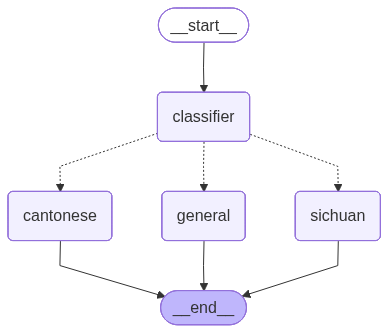

In [17]:
# 构建图

from typing import Literal
from langgraph.graph import StateGraph, START, END
from torch.export import graph_signature

builder = StateGraph(State)

builder.add_node("classifier", classifier_node)
builder.add_node("sichuan", sichuan_node)
builder.add_node("cantonese", cantonese_node)
builder.add_node("general", general_node)

builder.add_edge(START, "classifier")

def route_question(state: State) -> Literal["sichuan", "cantonese", "general"]:
    if "川菜" in state["topic"]:
        return "sichuan"
    elif "粤菜" in state["topic"]:
        return "cantonese"
    return "general"

builder.add_conditional_edges("classifier", route_question)

builder.add_edge("sichuan", END)
builder.add_edge("cantonese", END)
builder.add_edge("general", END)

graph = builder.compile()
graph


In [18]:
# 运行
result = graph.invoke({"question": "麻婆豆腐怎么做？"})
print(result["answer"])


content='好的，先生/女士，作为一名专业厨师，我很乐意为您呈现一道最正宗、最地道的「麻婆豆腐」。这道菜是川菜的灵魂之一，讲究的是“麻、辣、烫、鲜、香、酥、嫩”七味一体。请系好围裙，我们开始。\n\n### **正宗麻婆豆腐**\n\n这道菜的成功关键在于对细节和调料的精准把控。\n\n#### **第一部分：核心食材**\n\n**主料：**\n*   **豆腐：** 500克。务必选用**嫩豆腐**或**石膏豆腐**，口感滑嫩，能充分吸收汤汁。北豆腐（老豆腐）风味稍逊。\n*   **牛肉末：** 100克。传统上使用牛肉末，能带来独特的酥香。也可以用猪肉末，但风味不同。\n\n**灵魂调料（川菜之魂）：**\n*   **郫县豆瓣酱：** 2汤匙（约30克）。这是麻婆豆腐的“底色”，提供复合的咸香、辣味和红油。请选用陈年、颜色深红、油润的豆瓣酱。\n*   **豆豉：** 1汤匙。洗净后稍微剁碎，提供发酵的酱香，是形成复合味道的关键。\n*   **花椒：**\n    *   **花椒粉：** 1-2茶匙，用于最后提麻。\n    *   **花椒粒：** 1茶匙，用于煸炒增香。\n\n**辅料与调味：**\n*   **蒜苗/青蒜：** 2根，只取蒜苗白部分，斜切成“马耳朵”形。这是正宗麻婆豆腐的点睛之笔，提供独特的香气。\n*   **姜末：** 1茶匙\n*   **蒜末：** 1茶匙\n*   **料酒：** 1汤匙\n*   **酱油：** 1茶匙（提鲜，非主要咸味来源）\n*   **盐：** 酌情少量（因豆瓣酱已很咸）\n*   **白糖：** 1小撮（约1/4茶匙），用于调和味道，平衡辣味，引出鲜味。\n*   **水淀粉：** 适量（土豆淀粉或玉米淀粉与水1：2混合）\n\n#### **第二部分：专业步骤**\n\n**步骤一：预处理——奠定基础**\n\n1.  **豆腐处理：** 将豆腐切成约2厘米见方的小块。在沸水中加入一小勺盐，将豆腐块放入，用小火焯烫约2分钟。此步可：\n    *   去除豆腥味。\n    *   使豆腐不易碎。\n    *   让豆腐内部预热，后续烹饪更快入味。\n    捞出后，浸入冷水中备用。\n\n2.  **牛肉末处理：** 锅中放少量底油，放入牛肉末，中火煸炒至完全变色、水分收干、变得酥香

In [19]:
result["topic"]


AIMessage(content='川菜', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 2, 'prompt_tokens': 54, 'total_tokens': 56, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}, 'prompt_cache_hit_tokens': 0, 'prompt_cache_miss_tokens': 54}, 'model_provider': 'deepseek', 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_ffc7281d48_prod0820_fp8_kvcache', 'id': 'ee467dd4-575f-4bad-8829-1514ae13af9c', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--60a6b3a6-acfb-41de-af60-4bca7e218c9a-0', usage_metadata={'input_tokens': 54, 'output_tokens': 2, 'total_tokens': 56, 'input_token_details': {'cache_read': 0}, 'output_token_details': {}})

### 嵌入相似性路由

不依赖 LLM，通过计算用户查询与预设的“路由示例语句”之间的向量嵌入相似度来做出决策。

![](images/4_4_4.webp)

In [1]:
# 初始化模型

from langchain_deepseek import ChatDeepSeek
from langchain_huggingface import HuggingFaceEmbeddings

from dotenv import load_dotenv
import os
load_dotenv()

llm = ChatDeepSeek(
    model="deepseek-chat", 
    temperature=0, 
    api_key=os.getenv("DEEPSEEK_API_KEY")
    )

embeddings = HuggingFaceEmbeddings(model_name="models/bge/bge-small-zh-v1.5")


In [2]:
# 定义路由
sichuan_route_prompt = "你是一位处理川菜的专家。用户的问题是关于麻辣、辛香、重口味的菜肴，例如水煮鱼、麻婆豆腐、鱼香肉丝、宫保鸡丁、花椒、海椒等。"
cantonese_route_prompt = "你是一位处理粤菜的专家。用户的问题是关于清淡、鲜美、原汁原味的菜肴，例如白切鸡、老火靓汤、虾饺、云吞面等。"

route_prompts = [sichuan_route_prompt, cantonese_route_prompt]
route_names = ["川菜", "粤菜"]

# 向量化
route_prompt_embeddings = embeddings.embed_documents(route_prompts)
print(f"已定义 {len(route_names)} 个路由: {', '.join(route_names)}")


已定义 2 个路由: 川菜, 粤菜


In [ ]:
# 定义图状态
from typing import TypedDict

class State(TypedDict):
    question: str
    topic: str
    answer: str


In [ ]:
# 定义分类节点
from langchain_community.utils.math import cosine_similarity
import numpy as np

def classifier_node(state: State):
    
    query_embedding = embeddings.embed_query(state["question"])
    
    # 计算与各路由提示的余弦相似度
    similarity_scores = cosine_similarity([query_embedding], route_prompt_embeddings)[0]
    
    chosen_route_index = np.argmax(similarity_scores)
    chosen_route_name = route_names[chosen_route_index]
    
    return {"topic": chosen_route_name}


In [ ]:
# 定义菜系节点

# 川菜
def sichuan_node(state: State):
    
    sichuan_prompt = f"""
    
    你是一位川菜大厨。请用正宗的川菜做法，回答关于「{state["question"]}」的问题。
    
    """
    
    answer = llm.invoke(classifier_prompt)
    return {"answer": answer}

# 粤菜
def cantonese_node(state: State):
    
    cantonese_prompt = f"""
    
    你是一位粤菜大厨。请用正宗的粤菜做法，回答关于「{state["question"]}」的问题。
    
    """
    
    answer = llm.invoke(cantonese_prompt)
    return {"answer": answer}


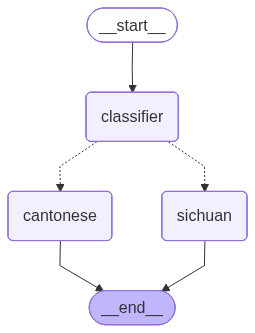

In [10]:
# 构建图

from typing import Literal
from langgraph.graph import StateGraph, START, END
from torch.export import graph_signature

builder = StateGraph(State)

builder.add_node("classifier", classifier_node)
builder.add_node("sichuan", sichuan_node)
builder.add_node("cantonese", cantonese_node)

builder.add_edge(START, "classifier")

def route_question(state: State) -> Literal["sichuan", "cantonese"]:
    if "川菜" in state["topic"]:
        return "sichuan"
    elif "粤菜" in state["topic"]:
        return "cantonese"

builder.add_conditional_edges("classifier", route_question)

builder.add_edge("sichuan", END)
builder.add_edge("cantonese", END)

graph = builder.compile()
graph


In [11]:
# 运行
result = graph.invoke({"question": "如何做一碗清淡的云吞面？"})
print(result["answer"])


content='好的，師傅！坐低飲啖茶，我同你慢慢講。做一碗正宗粵式雲吞麵，睇落簡單，但裏面嘅功夫一絲都馬虎不得。精髓就在於「清而不淡，鮮而不俗」，湯要清澈見底而味濃，雲吞要皮薄餡靚，麵要爽脆彈牙。跟住我嘅步驟，保證你做出嚟嘅雲吞麵有曬傳統風味。\n\n**第一：湯底 — 雲吞麵嘅靈魂**\n\n一碗靚雲吞麵，七成功夫在於湯。我哋要用「金華火腿」同「大地魚」呢兩樣法寶，唔可以用味精。\n\n*   **材料**：\n    *   大地魚（乾鯪魚）2-3條\n    *   蝦籽 約1湯匙（增加層次感，可選但強烈推薦）\n    *   金華火腿骨/火腿皮 約150克\n    *   豬筒骨 1大塊（約500克）\n    *   瘦肉 300克（吊湯用，令湯更清）\n    *   蝦殼 半斤（用嚟剝蝦仁嘅殼，唔好浪費）\n    *   清水 約4-5公升\n    *   老薑 2大塊，拍扁\n    *   果皮 1小塊\n\n*   **步驟**：\n    1.  **處理大地魚**：用乾鑊細火將大地魚兩面烘烤至金黃香脆，出曬香味。然後用乾淨嘅布包住，拍碎備用。呢一步係湯底鮮味嘅關鍵。\n    2.  **汆水**：將豬筒骨、瘦肉、金華火腿骨放入滾水中，大火煮5分鐘，撈起沖洗乾淨，去除血水和雜質。\n    3.  **熬湯**：大湯煲內放入所有材料（包括烤香嘅大地魚、蝦籽、蝦殼），加入清水，大火煲滾後，轉細火，**保持「蝦眼水」（即係微微滾起，有細細泡泡似蝦眼）嘅狀態**，熬至少4個鐘。記住，千萬唔好大火滾，否則湯會渾濁。\n    4.  **隔渣**：熬好後，用隔油網或者紗布將所有湯渣隔乾淨，最後得到嘅就係金黃色、清澈見底但味道極其鮮濃嘅上湯。臨用之前再加少少鹽調味即可，因為火腿同大地魚已經有鹹味。\n\n**第二：雲吞 — 皮薄餡靚，一口一隻**\n\n正宗廣東雲吞係細細粒，一口一隻，餡料講究鮮味同口感。\n\n*   **雲吞皮**：一定要買黃色嘅「全蛋雲吞皮」，薄而爽滑，唔會煮爛。\n*   **餡料**：\n    *   豬枚肉（豬頸背肉） 150克（三分肥七分瘦，帶嚟爽滑口感）\n    *   鮮蝦仁 200克（最好用基圍蝦，一半切粒，一半稍微拍扁，增加口感）\n    *   大地魚粉 1茶匙（將烘香嘅大地魚磨成粉，係秘密武器

In [12]:
result["topic"]


'粤菜'